# Topic Modeling with LDA

In this notebook, we will train a **Latent Dirichlet Allocation (LDA) model** on the NLTK sample of the **Reuters Corpus** (10,788 news documents totaling 1.3 million words). Then we will use the topics inferred by the LDA model as features to approach the document classification task on the same dataset.

We will use the _gensim_ implementation of LDA, so let's start with installation.

In [4]:
!pip install gensim

In [5]:
import nltk
nltk.download("reuters") # if necessary
from nltk.corpus import reuters

[nltk_data] Downloading package reuters to /Users/jason/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


Documents in the training set will have the word *train* in its file ID, we will use this to split the corpus into training and test set. 

Same as notebook `03-classification`, we will build a classifier to distinguish the most common topic in the corpus, "acq" (acqusitions). So we also record the topic label of each documents.

In [6]:
training_set = []
training_classifications = []

test_set = []
test_classifications = []

topic = "acq"

for file_id in reuters.fileids():
    if file_id.startswith("train"):
        training_set.append(reuters.words(file_id))
        if topic in reuters.categories(file_id):
            training_classifications.append(topic)
        else:
            training_classifications.append("not " + topic)
    else:
        test_set.append(reuters.words(file_id))
        if topic in reuters.categories(file_id):
            test_classifications.append(topic)
        else:
            test_classifications.append("not " + topic)
            
print("Train Size:", len(training_set))
print("Test Size:", len(test_set))

Train Size: 7769
Test Size: 3019


Now, let's do pre-processing for the documents in our Reuter Corpus. As we discussed in the lecture, good pre-processing practice is crucial for topic modelling. Hence we will use the following pre-processing steps:

1. Lowercase all words.
2. Removing stopwords.
3. Removing words shorter than 4 characters.
4. Removing word with too high/low frequency.

In [8]:
import logging
import operator

import gensim
from gensim import corpora

import nltk

# for gensim to output some progress information while it's training
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

en_stop = set(nltk.corpus.stopwords.words('english'))

def preprocessing(dataset):
    # we filter stopwords using nltk stopword list
    text_data = [[word.lower() for word in doc if (len(word)>4 and word.lower() not in en_stop) ] for doc in dataset]
    # Dictionary encapsulates the mapping between normalized words and their integer ids.
    dictionary = corpora.Dictionary(text_data)
    # no_below: Keep tokens which are contained in at least no_below documents.
    # no_above: Keep tokens which are contained in no more than no_above documents 
    #           (fraction of total corpus size, not an absolute number).
    dictionary.filter_extremes(no_below=10, no_above=0.5)
    # Filter out the 20 most frequent tokens that appear in the documents.
    dictionary.filter_n_most_frequent(20)
    # convert documents to BOW representations
    corpus = [dictionary.doc2bow(doc) for doc in text_data]
    
    return corpus, dictionary

preprocessed_train, train_dictionary = preprocessing(training_set)
preprocessed_test, test_dictionary = preprocessing(test_set)

2020-05-26 20:16:35,618 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-26 20:16:36,223 : INFO : built Dictionary(19497 unique tokens: ['bukhoosh', 'picks', 'latorre', 'stainless', 'shing']...) from 7769 documents (total 412952 corpus positions)
2020-05-26 20:16:36,259 : INFO : discarding 15633 tokens: [('alleviating', 1), ('arrivals', 5), ('arroba', 1), ('bahia', 4), ('carnival', 4), ('comissaria', 1), ('consignment', 3), ('covertible', 1), ('cruzados', 4), ('dificulties', 1)]...
2020-05-26 20:16:36,259 : INFO : keeping 3864 tokens which were in no less than 10 and no more than 3884 (=50.0%) documents
2020-05-26 20:16:36,275 : INFO : resulting dictionary: Dictionary(3864 unique tokens: ['buoyant', 'highly', 'shipping', 'utility', 'fresh']...)
2020-05-26 20:16:36,284 : INFO : discarding 20 tokens: [('company', 1836), ('would', 1553), ('share', 1253), ('billion', 1185), ('march', 1170), ('april', 1126), ('market', 1055), ('stock', 985), ('three', 966), ('record', 

Now we train our LDA model with the preprocessed training corpus. ```LdaModel``` is the implementation of LDA in gensim. Here we train the model for 10 passes with **50 topics**. Then, we print out the words associated with each topic.

In [36]:
num_topics = 50

#alpha = document-topic prior
#eta (beta in lecture) = topic-word prior
model = gensim.models.LdaModel(preprocessed_train, id2word=train_dictionary,
                               num_topics=num_topics, alpha='auto', eta='auto',
                               passes=10)

for topic_id in range(model.num_topics):
    # extract 10 top words for each topic
    topk = model.show_topic(topic_id, 10)
    topk_words = [ w for w, _ in topk ]

    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

2020-05-26 20:42:49,921 : INFO : using autotuned alpha, starting with [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
2020-05-26 20:42:49,927 : INFO : using serial LDA version on this node
2020-05-26 20:42:49,962 : INFO : running online (multi-pass) LDA training, 50 topics, 10 passes over the supplied corpus of 7769 documents, updating model once every 2000 documents, evaluating perplexity every 7769 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-26 20:42:49,964 : INFO : PROGRESS: pass 0, at document #2000/7769
2020-05-26 20:42:51,476 : INFO : optimized alpha [0.019572044, 0.019463345, 0.01937523, 0.01955752, 0.019303704, 0.019628156, 0.019287987, 0.019109435, 0.01939813, 0.019261688, 0.019756382, 0.01948754, 0

2020-05-26 20:42:56,315 : INFO : topic #23 (0.022): 0.103*"dividend" + 0.079*"prior" + 0.039*"payout" + 0.039*"quarterly" + 0.035*"payable" + 0.025*"preferred" + 0.023*"common" + 0.023*"shareholders" + 0.020*"regular" + 0.019*"holders"
2020-05-26 20:42:56,318 : INFO : topic #29 (0.022): 0.027*"credit" + 0.015*"offer" + 0.014*"stake" + 0.014*"includes" + 0.014*"pacific" + 0.012*"extraordinary" + 0.011*"holding" + 0.011*"canadian" + 0.010*"pretax" + 0.010*"resources"
2020-05-26 20:42:56,326 : INFO : topic #27 (0.022): 0.019*"government" + 0.012*"foreign" + 0.007*"economic" + 0.007*"strike" + 0.006*"business" + 0.005*"added" + 0.005*"interest" + 0.005*"chairman" + 0.005*"companies" + 0.005*"payments"
2020-05-26 20:42:56,328 : INFO : topic diff=1.662563, rho=0.500000
2020-05-26 20:42:56,347 : INFO : PROGRESS: pass 1, at document #2000/7769
2020-05-26 20:42:57,351 : INFO : optimized alpha [0.020836003, 0.019783096, 0.020296566, 0.020989604, 0.019513465, 0.018498288, 0.021532979, 0.019768348

2020-05-26 20:43:01,731 : INFO : topic #12 (0.019): 0.039*"minister" + 0.023*"sector" + 0.022*"ceiling" + 0.021*"employers" + 0.019*"great" + 0.019*"venezuela" + 0.017*"official" + 0.013*"uruguay" + 0.012*"informal" + 0.012*"union"
2020-05-26 20:43:01,732 : INFO : topic #17 (0.024): 0.057*"earnings" + 0.031*"expects" + 0.019*"revenues" + 0.018*"financial" + 0.017*"quarter" + 0.014*"agreement" + 0.013*"reported" + 0.012*"common" + 0.011*"second" + 0.011*"transaction"
2020-05-26 20:43:01,733 : INFO : topic #27 (0.025): 0.026*"government" + 0.010*"foreign" + 0.008*"economic" + 0.007*"added" + 0.006*"growth" + 0.006*"chairman" + 0.006*"years" + 0.006*"payments" + 0.005*"companies" + 0.005*"financial"
2020-05-26 20:43:01,735 : INFO : topic #23 (0.025): 0.134*"dividend" + 0.097*"prior" + 0.050*"quarterly" + 0.046*"payout" + 0.041*"payable" + 0.035*"preferred" + 0.028*"common" + 0.024*"holders" + 0.024*"regular" + 0.022*"shareholders"
2020-05-26 20:43:01,741 : INFO : topic diff=1.345919, rho=

2020-05-26 20:43:07,075 : INFO : merging changes from 1769 documents into a model of 7769 documents
2020-05-26 20:43:07,089 : INFO : topic #5 (0.019): 0.152*"offer" + 0.076*"cyclops" + 0.074*"tender" + 0.057*"dixons" + 0.029*"cyacq" + 0.022*"citicorp" + 0.021*"video" + 0.018*"offers" + 0.018*"tendered" + 0.015*"outstanding"
2020-05-26 20:43:07,090 : INFO : topic #12 (0.020): 0.052*"minister" + 0.023*"official" + 0.022*"ceiling" + 0.022*"sector" + 0.022*"venezuela" + 0.021*"great" + 0.020*"employers" + 0.014*"labour" + 0.013*"uruguay" + 0.013*"union"
2020-05-26 20:43:07,091 : INFO : topic #17 (0.027): 0.061*"earnings" + 0.034*"expects" + 0.021*"revenues" + 0.020*"financial" + 0.014*"agreement" + 0.013*"reported" + 0.012*"quarter" + 0.012*"transaction" + 0.012*"business" + 0.011*"earned"
2020-05-26 20:43:07,093 : INFO : topic #27 (0.027): 0.029*"government" + 0.009*"economic" + 0.009*"foreign" + 0.008*"growth" + 0.008*"years" + 0.008*"added" + 0.007*"chairman" + 0.006*"financial" + 0.006

2020-05-26 20:43:12,617 : INFO : merging changes from 1769 documents into a model of 7769 documents
2020-05-26 20:43:12,630 : INFO : topic #5 (0.019): 0.174*"offer" + 0.083*"tender" + 0.068*"cyclops" + 0.050*"dixons" + 0.026*"cyacq" + 0.019*"citicorp" + 0.019*"video" + 0.019*"offers" + 0.017*"outstanding" + 0.017*"tendered"
2020-05-26 20:43:12,632 : INFO : topic #12 (0.020): 0.060*"minister" + 0.027*"official" + 0.023*"venezuela" + 0.022*"great" + 0.022*"ceiling" + 0.020*"sector" + 0.020*"employers" + 0.015*"labour" + 0.012*"uruguay" + 0.012*"ecuador"
2020-05-26 20:43:12,633 : INFO : topic #17 (0.029): 0.064*"earnings" + 0.037*"expects" + 0.023*"revenues" + 0.021*"financial" + 0.013*"business" + 0.012*"transaction" + 0.012*"earned" + 0.012*"reported" + 0.011*"operating" + 0.011*"agreement"
2020-05-26 20:43:12,634 : INFO : topic #27 (0.030): 0.031*"government" + 0.009*"economic" + 0.009*"growth" + 0.009*"years" + 0.009*"added" + 0.008*"foreign" + 0.007*"financial" + 0.007*"chairman" + 0

2020-05-26 20:43:18,147 : INFO : merging changes from 1769 documents into a model of 7769 documents
2020-05-26 20:43:18,159 : INFO : topic #5 (0.020): 0.182*"offer" + 0.088*"tender" + 0.062*"cyclops" + 0.046*"dixons" + 0.024*"cyacq" + 0.020*"offers" + 0.019*"offered" + 0.018*"video" + 0.018*"citicorp" + 0.017*"outstanding"
2020-05-26 20:43:18,161 : INFO : topic #42 (0.021): 0.126*"deficit" + 0.107*"surplus" + 0.064*"account" + 0.054*"current" + 0.048*"rubber" + 0.030*"february" + 0.026*"balance" + 0.025*"january" + 0.023*"allegheny" + 0.022*"hughes"
2020-05-26 20:43:18,162 : INFO : topic #34 (0.032): 0.029*"prices" + 0.026*"world" + 0.015*"demand" + 0.012*"exports" + 0.012*"economic" + 0.012*"countries" + 0.012*"domestic" + 0.011*"economy" + 0.010*"government" + 0.009*"production"
2020-05-26 20:43:18,165 : INFO : topic #27 (0.033): 0.032*"government" + 0.010*"economic" + 0.010*"growth" + 0.009*"years" + 0.009*"added" + 0.007*"financial" + 0.007*"chairman" + 0.007*"budget" + 0.007*"fore

2020-05-26 20:43:23,606 : INFO : merging changes from 1769 documents into a model of 7769 documents
2020-05-26 20:43:23,618 : INFO : topic #5 (0.021): 0.186*"offer" + 0.090*"tender" + 0.059*"cyclops" + 0.044*"dixons" + 0.022*"cyacq" + 0.020*"offers" + 0.019*"offered" + 0.018*"outstanding" + 0.017*"video" + 0.017*"citicorp"
2020-05-26 20:43:23,621 : INFO : topic #42 (0.022): 0.127*"deficit" + 0.110*"surplus" + 0.065*"account" + 0.057*"current" + 0.048*"rubber" + 0.030*"february" + 0.027*"balance" + 0.026*"january" + 0.024*"exports" + 0.023*"allegheny"
2020-05-26 20:43:23,623 : INFO : topic #34 (0.035): 0.030*"prices" + 0.026*"world" + 0.015*"demand" + 0.012*"exports" + 0.012*"economic" + 0.012*"domestic" + 0.011*"countries" + 0.011*"economy" + 0.010*"government" + 0.010*"production"
2020-05-26 20:43:23,625 : INFO : topic #27 (0.036): 0.033*"government" + 0.010*"growth" + 0.010*"economic" + 0.010*"years" + 0.010*"added" + 0.009*"budget" + 0.008*"financial" + 0.007*"chairman" + 0.007*"spe

2020-05-26 20:43:29,198 : INFO : merging changes from 1769 documents into a model of 7769 documents
2020-05-26 20:43:29,209 : INFO : topic #5 (0.021): 0.188*"offer" + 0.091*"tender" + 0.057*"cyclops" + 0.042*"dixons" + 0.022*"cyacq" + 0.021*"offers" + 0.019*"offered" + 0.018*"outstanding" + 0.017*"video" + 0.016*"citicorp"
2020-05-26 20:43:29,211 : INFO : topic #42 (0.022): 0.126*"deficit" + 0.112*"surplus" + 0.066*"account" + 0.058*"current" + 0.047*"rubber" + 0.031*"february" + 0.028*"balance" + 0.027*"exports" + 0.026*"january" + 0.022*"allegheny"
2020-05-26 20:43:29,212 : INFO : topic #34 (0.038): 0.031*"prices" + 0.026*"world" + 0.015*"demand" + 0.013*"domestic" + 0.012*"economic" + 0.012*"exports" + 0.011*"economy" + 0.011*"countries" + 0.010*"production" + 0.010*"government"
2020-05-26 20:43:29,216 : INFO : topic #27 (0.040): 0.033*"government" + 0.011*"growth" + 0.010*"economic" + 0.010*"budget" + 0.010*"years" + 0.010*"added" + 0.008*"financial" + 0.007*"chairman" + 0.007*"spe

2020-05-26 20:43:34,541 : INFO : merging changes from 1769 documents into a model of 7769 documents
2020-05-26 20:43:34,556 : INFO : topic #5 (0.022): 0.189*"offer" + 0.091*"tender" + 0.055*"cyclops" + 0.041*"dixons" + 0.021*"cyacq" + 0.021*"offers" + 0.020*"offered" + 0.018*"outstanding" + 0.017*"video" + 0.016*"citicorp"
2020-05-26 20:43:34,557 : INFO : topic #42 (0.023): 0.125*"deficit" + 0.114*"surplus" + 0.067*"account" + 0.058*"current" + 0.047*"rubber" + 0.032*"february" + 0.030*"exports" + 0.029*"balance" + 0.025*"january" + 0.023*"imports"
2020-05-26 20:43:34,558 : INFO : topic #34 (0.040): 0.032*"prices" + 0.027*"world" + 0.015*"demand" + 0.013*"domestic" + 0.012*"economic" + 0.012*"exports" + 0.011*"economy" + 0.011*"countries" + 0.010*"production" + 0.010*"government"
2020-05-26 20:43:34,561 : INFO : topic #23 (0.042): 0.184*"dividend" + 0.112*"prior" + 0.066*"quarterly" + 0.052*"payout" + 0.050*"payable" + 0.044*"preferred" + 0.029*"declared" + 0.029*"holders" + 0.028*"reg

2020-05-26 20:43:39,864 : INFO : merging changes from 1769 documents into a model of 7769 documents
2020-05-26 20:43:39,877 : INFO : topic #5 (0.023): 0.190*"offer" + 0.092*"tender" + 0.054*"cyclops" + 0.040*"dixons" + 0.021*"offers" + 0.021*"cyacq" + 0.020*"offered" + 0.018*"outstanding" + 0.017*"video" + 0.016*"citicorp"
2020-05-26 20:43:39,878 : INFO : topic #42 (0.023): 0.125*"deficit" + 0.114*"surplus" + 0.067*"account" + 0.059*"current" + 0.046*"rubber" + 0.033*"exports" + 0.032*"february" + 0.029*"balance" + 0.026*"imports" + 0.025*"january"
2020-05-26 20:43:39,880 : INFO : topic #34 (0.043): 0.032*"prices" + 0.027*"world" + 0.015*"demand" + 0.013*"domestic" + 0.012*"economic" + 0.012*"exports" + 0.012*"economy" + 0.011*"production" + 0.011*"countries" + 0.009*"industry"
2020-05-26 20:43:39,882 : INFO : topic #23 (0.044): 0.185*"dividend" + 0.113*"prior" + 0.066*"quarterly" + 0.052*"payout" + 0.051*"payable" + 0.045*"preferred" + 0.030*"declared" + 0.029*"holders" + 0.028*"regul

2020-05-26 20:43:45,162 : INFO : merging changes from 1769 documents into a model of 7769 documents
2020-05-26 20:43:45,176 : INFO : topic #42 (0.024): 0.124*"deficit" + 0.115*"surplus" + 0.067*"account" + 0.058*"current" + 0.046*"rubber" + 0.034*"exports" + 0.032*"february" + 0.029*"balance" + 0.027*"imports" + 0.025*"january"
2020-05-26 20:43:45,177 : INFO : topic #5 (0.024): 0.190*"offer" + 0.091*"tender" + 0.053*"cyclops" + 0.040*"dixons" + 0.021*"offers" + 0.020*"cyacq" + 0.020*"offered" + 0.018*"outstanding" + 0.017*"video" + 0.016*"citicorp"
2020-05-26 20:43:45,178 : INFO : topic #34 (0.046): 0.032*"prices" + 0.026*"world" + 0.015*"demand" + 0.013*"domestic" + 0.012*"economic" + 0.012*"exports" + 0.012*"economy" + 0.011*"production" + 0.010*"countries" + 0.010*"forecast"
2020-05-26 20:43:45,179 : INFO : topic #23 (0.046): 0.185*"dividend" + 0.113*"prior" + 0.066*"quarterly" + 0.052*"payout" + 0.052*"payable" + 0.045*"preferred" + 0.031*"declared" + 0.028*"holders" + 0.028*"regul

0: quarter fourth third results reported losses second shell income earlier
1: sugar tonnes export wheat traders tonne shipment intervention tender sources
2: crude energy barrels petroleum prices production texas barrel refinery reserves
3: committee house meeting administration european proposal proposed president could industry
4: board split shareholders raises effective common directors meeting increase raised
5: offer tender cyclops dixons offers cyacq offered outstanding video citicorp
6: subsidiary owned division acquired services terms mining health wholly based
7: exploration drilling industries block offshore mexico northern telecom project mines
8: banks loans commercial banking interest deposits assets funds bankers credit
9: merger agreement management proposed shareholders merge waste companies approved transaction
10: stake securities investment exchange commission total common bought express shearson
11: tonnes exports imports production total maize import figures outp

### Document classification with topic features

Since we will be using topic distribution of documents as features for our classifiers, we need to extract topic vector for each document using the LDA model we trained.

In [37]:
train_vectors = [model[doc] for doc in preprocessed_train]
test_vectors = [model[doc] for doc in preprocessed_test]

print(train_vectors[0])

[(1, 0.08835984), (11, 0.07526854), (12, 0.109812796), (18, 0.025732666), (22, 0.053181678), (33, 0.047094624), (35, 0.013233464), (37, 0.03464374), (43, 0.15859266), (44, 0.28209603), (47, 0.018432979), (48, 0.061606232), (49, 0.022008965)]


Now we convert the sparse vectors to dense matrices which can be used as input to the classifiers.

In [38]:
import numpy as np

def to_matrix(vectors, num_topics):
    matrix = np.zeros((len(vectors), num_topics))
    for i in range(len(vectors)):
        for t in vectors[i]:
            matrix[i][t[0]] = t[1]
    return matrix

train_matrix = to_matrix(train_vectors, num_topics)
test_matrix = to_matrix(test_vectors, num_topics)

print(train_matrix.shape)
print(test_matrix.shape)

(7769, 50)
(3019, 50)


Define a wide range of basic classifiers. We will do a 10-fold cross validation on training set for model selection.

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

clfs = [KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier()
        ,LinearSVC(),LogisticRegression()]

In [40]:
from sklearn import model_selection
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def do_multiple_10foldcrossvalidation(clfs,data,classifications):
    for clf in clfs:
        predictions = model_selection.cross_val_predict(clf, data,classifications, cv=10)
        print (clf)
        print ("accuracy")
        print (accuracy_score(classifications,predictions))
        print (classification_report(classifications,predictions))
        
do_multiple_10foldcrossvalidation(clfs, train_matrix, training_classifications)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
accuracy
0.9030763289998713
              precision    recall  f1-score   support

         acq       0.88      0.63      0.73      1650
     not acq       0.91      0.98      0.94      6119

    accuracy                           0.90      7769
   macro avg       0.89      0.80      0.84      7769
weighted avg       0.90      0.90      0.90      7769

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
accuracy
0.9062942463637533
   

[0.7105001656177542, 0.6565087777409738, 0.6826763829082477, 0.7174561112951309, 0.7191122888373633]


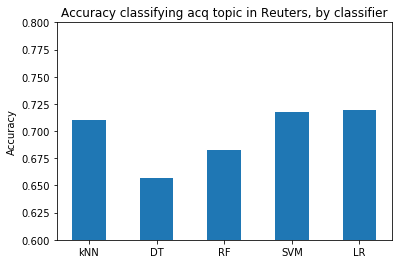

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

def test_and_graph(clfs,training_data,training_classifications,test_data,test_classifications):
    accuracies = []
    for clf in clfs:
        clf.fit(training_data,training_classifications)
        predictions = clf.predict(test_data)
        accuracies.append(accuracy_score(test_classifications,predictions))
    print (accuracies)
    p = plt.bar([num + 0.25 for num in range(len(clfs))], accuracies,0.5)
    plt.ylabel('Accuracy')
    plt.title('Accuracy classifying acq topic in Reuters, by classifier')
    plt.ylim([0.6,0.8])
    plt.xticks([num + 0.25 for num in range(len(clfs))], ('kNN', 'DT', 'RF', 'SVM', 'LR'))
    plt.show()

test_and_graph(clfs,train_matrix,training_classifications,test_matrix,test_classifications)